In [1]:
!pip install tensorflow datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
 #Importing Libraries
from datasets import load_dataset
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Dropout, Bidirectional, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np
import nltk
import os

In [3]:
# Enable mixed precision (Optional but beneficial for modern GPUs)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Verify GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow is using the GPU.")
else:
    print("No GPU found. Please enable GPU acceleration.")

Num GPUs Available:  1
TensorFlow is using the GPU.


In [4]:
# Download GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip


--2024-12-10 01:04:26--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-12-10 01:04:27--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-12-10 01:04:27--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [5]:
# Load the SQuAD dataset
squad_2 = load_dataset('squad_v2')
train_data = squad_2['train']
val_data = squad_2['validation']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

In [6]:
# Initialize Tokenizer
tokenizer = Tokenizer(oov_token='<OOV>')
all_texts = (
    [example['context'] for example in train_data] +
    [example['question'] for example in train_data] +
    [answer for example in train_data for answer in example['answers']['text']]
)
tokenizer.fit_on_texts(all_texts)
vocab_size = len(tokenizer.word_index) + 1

In [7]:
# Define maximum sequence lengths for context and question
max_context_len = 400
max_question_len = 50

In [8]:
# Embedding dimensions and LSTM units
embedding_dim = 100  # Adjust to match the GloVe embedding dimension you choose
hidden_size = 128



In [9]:
# Load GloVe embeddings into a dictionary
embedding_index = {}
glove_file = f'glove.6B.{embedding_dim}d.txt'
with open(glove_file, 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

print(f'Loaded {len(embedding_index)} word vectors.')

Loaded 400000 word vectors.


In [10]:
# Create the embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if index >= vocab_size:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

print(f'Created embedding matrix with shape {embedding_matrix.shape}')

Created embedding matrix with shape (94578, 100)


In [11]:
# Preprocessing functions
def preprocess_example(example):
    # Tokenize context and question
    context_tokens = tokenizer.texts_to_sequences([example['context']])[0][:max_context_len]
    question_tokens = tokenizer.texts_to_sequences([example['question']])[0][:max_question_len]

    # Pad sequences
    context_padded = pad_sequences([context_tokens], maxlen=max_context_len, padding='post')[0]
    question_padded = pad_sequences([question_tokens], maxlen=max_question_len, padding='post')[0]

    # Initialize start and end labels
    start_labels = np.zeros(max_context_len)
    end_labels = np.zeros(max_context_len)

    # Check if the question is answerable and that answers exist
    if not example.get('is_impossible', False) and example['answers']['text']:
        # Locate the answer tokens
        answer_text = example['answers']['text'][0]
        start_char = example['answers']['answer_start'][0]
        answer_tokens = tokenizer.texts_to_sequences([answer_text])[0]

        # Find the start and end indices in context_tokens
        for idx in range(len(context_tokens) - len(answer_tokens) + 1):
            if context_tokens[idx:idx+len(answer_tokens)] == answer_tokens:
                start_labels[idx] = 1
                end_labels[idx + len(answer_tokens) - 1] = 1
                break

    return context_padded, question_padded, start_labels, end_labels

In [12]:
# Create training and validation datasets
batch_size = 32  # Adjust based on GPU memory


def create_tf_dataset(data, batch_size):
    # Preprocess examples and filter out None
    processed_data = []
    for idx, example in enumerate(data):
        if idx == 0:
            print("Type of example:", type(example))
            print("Example keys:", example.keys())
        processed_example = preprocess_example(example)
        if processed_example is not None:
            processed_data.append(processed_example)

    # Prepare input arrays
    contexts = np.array([item[0] for item in processed_data])
    questions = np.array([item[1] for item in processed_data])
    start_labels = np.array([item[2] for item in processed_data])
    end_labels = np.array([item[3] for item in processed_data])

    # Create TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((
        {'context_input': contexts, 'question_input': questions},
        {'start_position': start_labels, 'end_position': end_labels}
    ))
    dataset = dataset.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset
train_dataset = create_tf_dataset(train_data.select(range(20000)), batch_size)
val_dataset = create_tf_dataset(val_data.select(range(5000)), batch_size)

Type of example: <class 'dict'>
Example keys: dict_keys(['id', 'title', 'context', 'question', 'answers'])
Type of example: <class 'dict'>
Example keys: dict_keys(['id', 'title', 'context', 'question', 'answers'])


In [13]:
# Define the model using functional API
with tf.device('/GPU:0'):
    # Input layers
    context_input = Input(shape=(max_context_len,), name='context_input')
    question_input = Input(shape=(max_question_len,), name='question_input')

    # Shared embedding layer (set trainable to True for fine-tuning)
    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        embeddings_initializer=Constant(embedding_matrix),
        trainable=False,
        dtype='float32'  # Embedding layer needs to be float32
    )

    # Embed inputs
    context_embedding = embedding_layer(context_input)
    question_embedding = embedding_layer(question_input)

    # LSTM Encoding with L2 Regularization
    context_lstm = Bidirectional(
        LSTM(units=hidden_size, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    )(context_embedding)
    question_lstm = Bidirectional(
        LSTM(units=hidden_size, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    )(question_embedding)

    # Attention Mechanism
    attention = tf.keras.layers.Attention()([context_lstm, question_lstm])

    # Combine context and attention outputs
    combined = Concatenate()([context_lstm, attention])

    # Further processing
    lstm_combined = LSTM(
        units=hidden_size, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(1e-4)
    )(combined)

    # Flatten and Dropout
    lstm_flattened = Flatten()(lstm_combined)
    dropout = Dropout(0.4)(lstm_flattened)  # Increased dropout rate to prevent overfitting

    # Output layers
    start_output = Dense(
        max_context_len, activation='softmax', name='start_position', kernel_regularizer=tf.keras.regularizers.l2(1e-4)
    )(dropout)
    end_output = Dense(
        max_context_len, activation='softmax', name='end_position', kernel_regularizer=tf.keras.regularizers.l2(1e-4)
    )(dropout)

In [14]:
# Define the model
model = Model(inputs=[context_input, question_input], outputs=[start_output, end_output])

In [15]:

# Custom metrics (need to be adapted for mixed precision)
def exact_match(y_true, y_pred):
    y_pred_idx = tf.argmax(y_pred, axis=-1)
    y_true_idx = tf.argmax(y_true, axis=-1)
    matches = tf.cast(tf.equal(y_true_idx, y_pred_idx), dtype=tf.float32)
    return tf.reduce_mean(matches)

def f1_score(y_true, y_pred):
    y_pred_idx = tf.argmax(y_pred, axis=-1)
    y_true_idx = tf.argmax(y_true, axis=-1)
    tp = tf.cast(tf.equal(y_true_idx, y_pred_idx), dtype=tf.float32)
    precision = tp / (tf.reduce_sum(y_pred_idx) + tf.keras.backend.epsilon())
    recall = tp / (tf.reduce_sum(y_true_idx) + tf.keras.backend.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return tf.reduce_mean(f1)


In [16]:
# Compile the model with tuned hyperparameters
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)  # Reduced learning rate for stability
if mixed_precision.global_policy().name == 'mixed_float16':
    optimizer = mixed_precision.LossScaleOptimizer(optimizer)

model.compile(
    optimizer=optimizer,
    loss={'start_position': 'categorical_crossentropy', 'end_position': 'categorical_crossentropy'},
    metrics={'start_position': [exact_match], 'end_position': [exact_match]},
)

# Add callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ context_input             │ (None, 400)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ question_input            │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 50, 100)        │      9,457,800 │ context_input[0][0],   │
│                           │                        │                │ question_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 400, 100)       │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_1 (Cast)             │ (None, 50, 100)        │              0 │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 400, 256)       │        234,496 │ cast[0][0]             │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 50, 256)        │        234,496 │ cast_1[0][0]           │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 400, 256)       │              0 │ bidirectional[0][0],   │
│                           │                        │                │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 400, 512)       │              0 │ bidirectional[0][0],   │
│                           │                        │                │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 400, 128)       │        328,192 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 51200)          │              0 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 51200)          │              0 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ start_position (Dense)    │ (None, 400)            │     20,480,400 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ end_position (Dense)      │ (None, 400)            │     20,480,400 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 51,215,784 (195.37 MB)

 Trainable params: 41,757,984 (159.29 MB)

 Non-trainable params: 9,457,800 (36.08 MB)

In [ ]:
# Train the model
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=callbacks
)

# Save the model
model.save('qa_model_gpu.keras')

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 117ms/step - end_position_exact_match: 0.1023 - end_position_loss: 3.7135 - loss: 7.7288 - start_position_exact_match: 0.0111 - start_position_loss: 3.7333 - val_end_position_exact_match: 0.3639 - val_end_position_loss: 2.3887 - val_loss: 5.0410 - val_start_position_exact_match: 0.0090 - val_start_position_loss: 2.4106
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - end_position_exact_match: 0.0997 - end_position_loss: 3.3080 - loss: 6.8770 - start_position_exact_match: 0.0187 - start_position_loss: 3.3275 - val_end_position_exact_match: 0.0732 - val_end_position_loss: 2.4005 - val_loss: 5.0675 - val_start_position_exact_match: 0.0078 - val_start_position_loss: 2.4267
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - end_position_exact_match: 0.0803 - end_position_loss: 2.9458 - loss: 6.1399 - start_position_exact_match: 0.0320 - start_position_loss: 2.9598 - val_end_position_exact_match: 0.0812 - val_end_position_loss: 2.437

In [ ]:
# Inference function
def preprocess_inference(context, question):
    context_tokens = tokenizer.texts_to_sequences([context])[0][:max_context_len]
    question_tokens = tokenizer.texts_to_sequences([question])[0][:max_question_len]

    context_padded = pad_sequences([context_tokens], maxlen=max_context_len, padding='post')
    question_padded = pad_sequences([question_tokens], maxlen=max_question_len, padding='post')

    return {'context_input': context_padded, 'question_input': question_padded}, context_tokens

def decode_answer(context_tokens, start_prob, end_prob):
    start_index = np.argmax(start_prob)
    end_index = np.argmax(end_prob)

    if end_index < start_index:
        end_index = start_index

    answer_tokens = context_tokens[start_index:end_index+1]
    answer_words = tokenizer.sequences_to_texts([answer_tokens])[0]

    return answer_words

# Example inference
context = "The Apollo program was the third United States human spaceflight program carried out by NASA, responsible for landing the first humans on the Moon from 1969 to 1972."
question = "What program was responsible for landing humans on the Moon?"

inputs, context_tokens = preprocess_inference(context, question)
start_prob, end_prob = model.predict(inputs)
answer = decode_answer(context_tokens, start_prob[0], end_prob[0])

print("Question:", question)
print("Answer:", answer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
Question: What program was responsible for landing humans on the Moon?
Answer: apollo


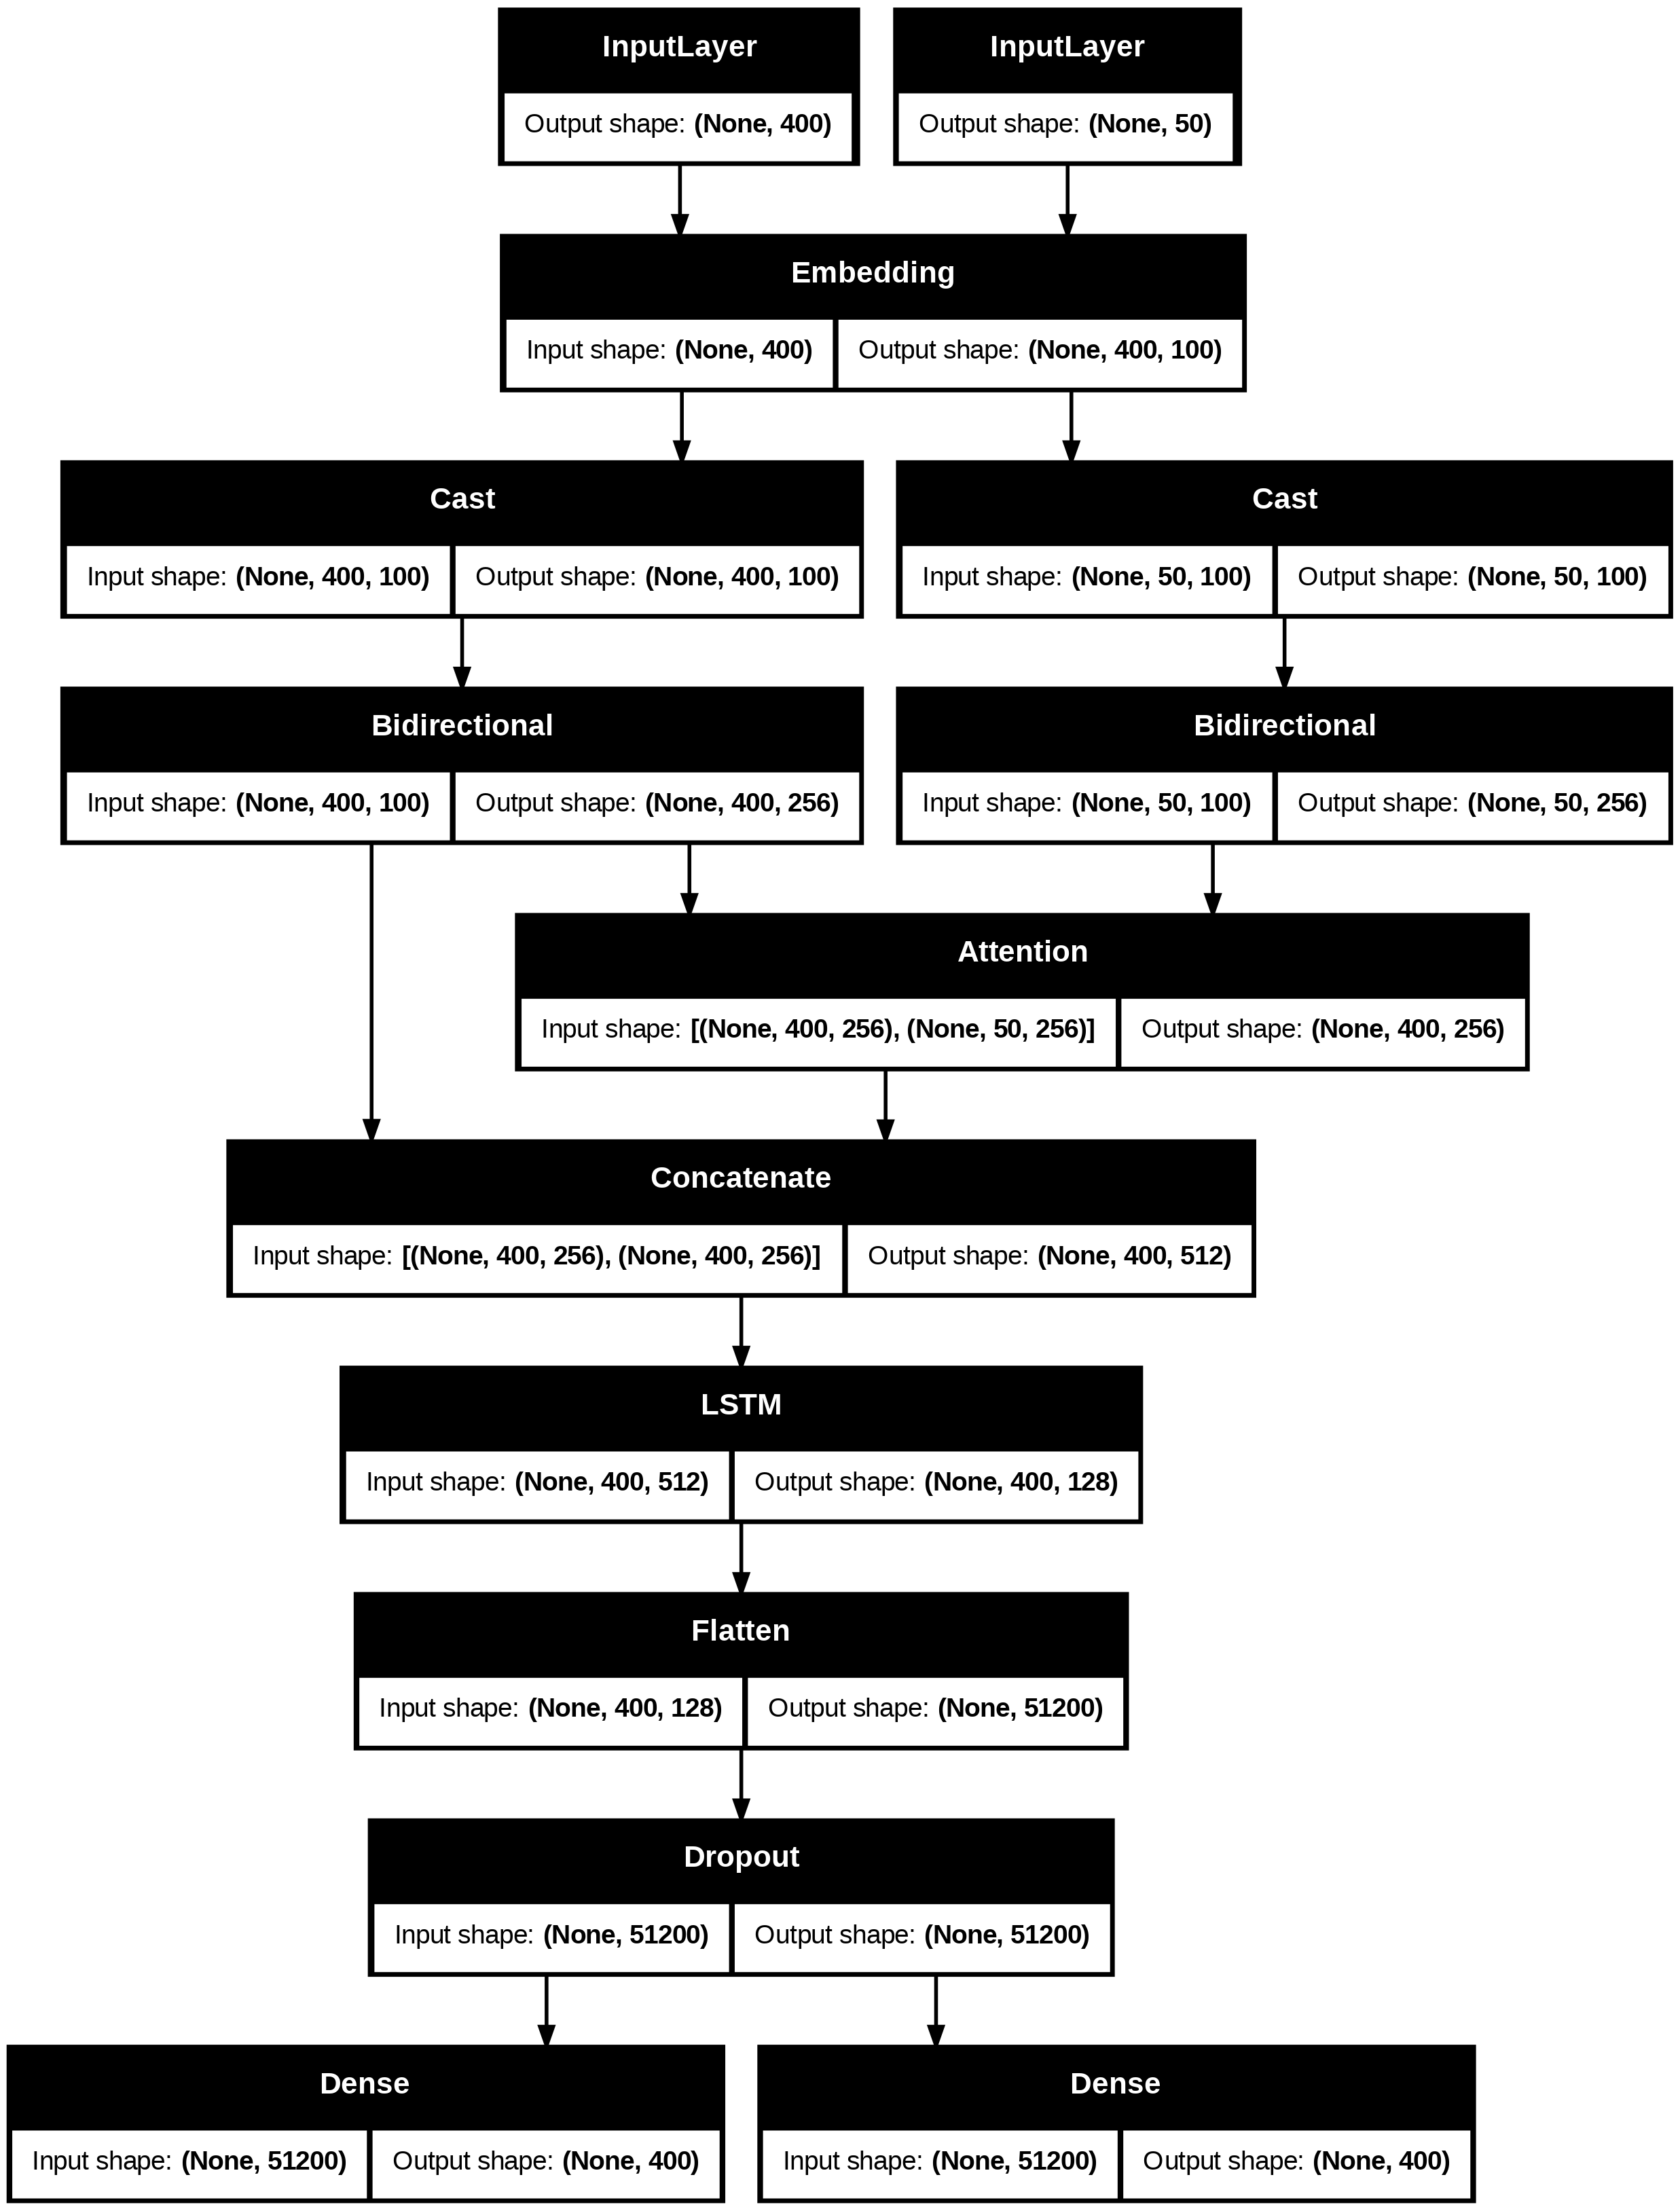

In [ ]:
# Visualize the model architecture (optional)
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

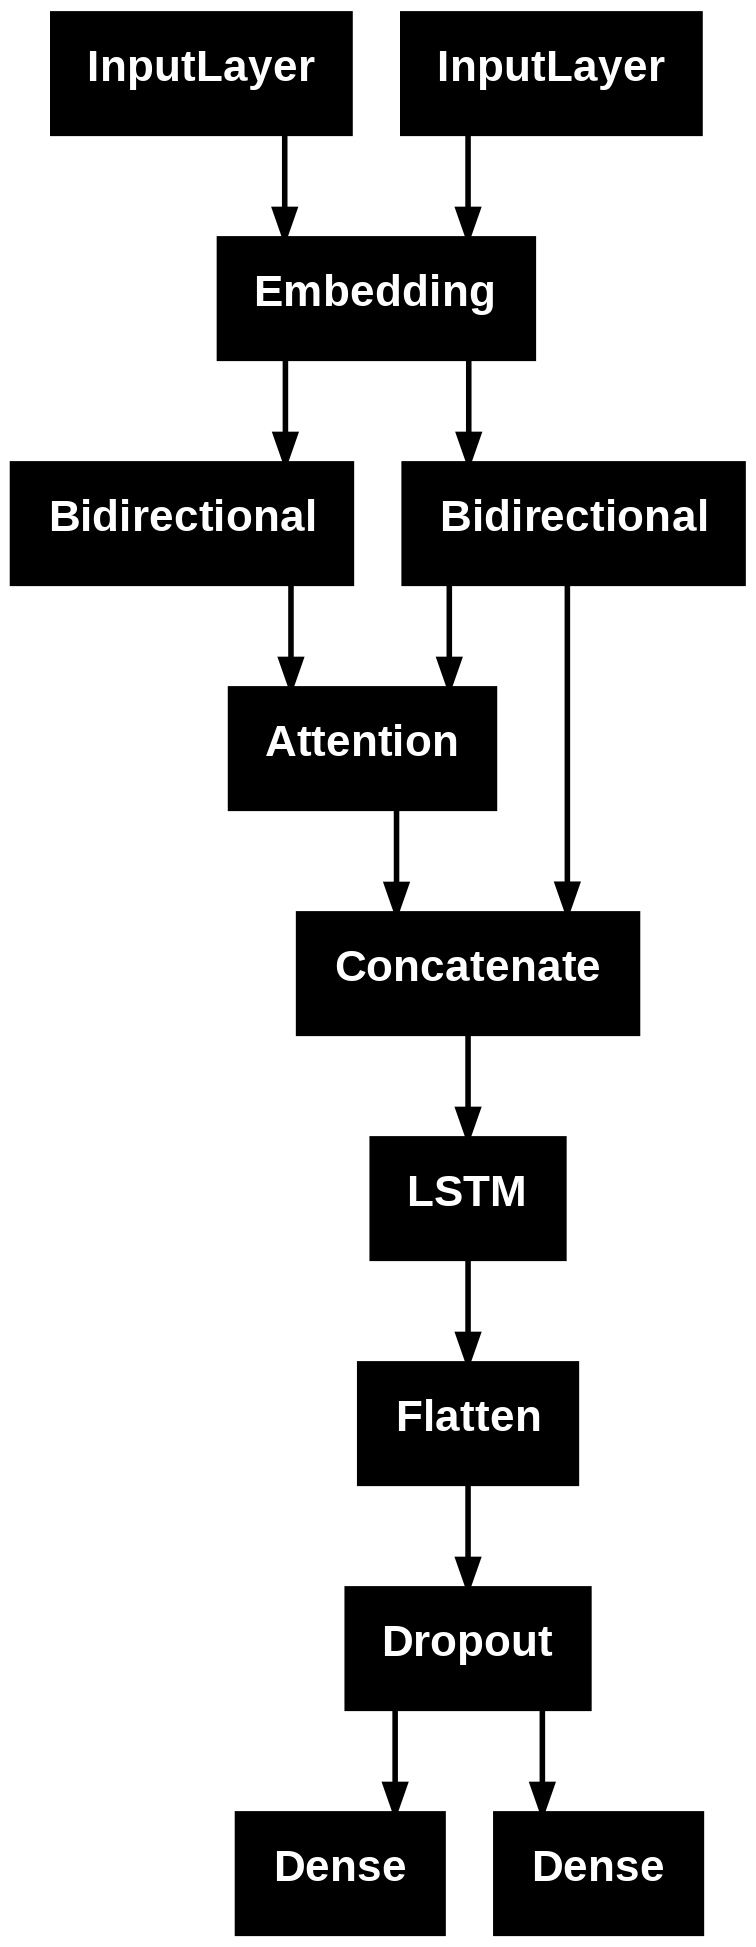

In [ ]:
plot_model(model)

# F1_score

In [ ]:
def f1_score(y_true, y_pred):
    # Convert softmax probabilities to token indices
    y_pred_idx = K.argmax(y_pred, axis=-1)
    y_true_idx = K.argmax(y_true, axis=-1)

    # Calculate true positives, false positives, and false negatives
    true_positives = K.sum(K.cast(y_true_idx * y_pred_idx, dtype=tf.float32))
    predicted_positives = K.sum(K.cast(y_pred_idx, dtype=tf.float32))
    actual_positives = K.sum(K.cast(y_true_idx, dtype=tf.float32))

    # Precision, recall, and F1 score
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (actual_positives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return f1

In [ ]:
# Define and compile the model with F1 score as the metric
model_f1 = Model(inputs=[context_input, question_input], outputs=[start_output, end_output])
model_f1.compile(optimizer='adam', loss='categorical_crossentropy', metrics={'start_position': f1_score, 'end_position': f1_score})

In [ ]:
model_f1.fit(
    [context_inputs, question_inputs],
    [start_labels, end_labels],
    batch_size=8,
    epochs=5,
    validation_split=0.1
)

Epoch 1/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 498s 433ms/step - end_position_f1_score: 35.1219 - loss: 18.4336 - start_position_f1_score: 31.8406 - val_end_position_f1_score: 25.4420 - val_loss: 102.2814 - val_start_position_f1_score: 26.7100
Epoch 2/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 485s 431ms/step - end_position_f1_score: 39.2906 - loss: 90.0215 - start_position_f1_score: 37.5253 - val_end_position_f1_score: 24.0349 - val_loss: 206.9064 - val_start_position_f1_score: 21.8112
Epoch 3/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 502s 431ms/step - end_position_f1_score: 43.2130 - loss: 151.0085 - start_position_f1_score: 39.7831 - val_end_position_f1_score: 29.9682 - val_loss: 219.7875 - val_start_position_f1_score: 30.0789
Epoch 4/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 502s 431ms/step - end_position_f1_score: 44.2161 - loss: 210.8477 - start_position_f1_score: 41.0687 - val_end_position_f1_score: 24.5326 - val_loss: 354.5160 - val_start_position_f1_score: 22.8468
Epoch 5/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 487s 

In [ ]:
def preprocess_inference(context, question):
    # Tokenize and pad context and question
    context_tokens = tokenizer.texts_to_sequences([context])[0]
    question_tokens = tokenizer.texts_to_sequences([question])[0]

    context_padded = pad_sequences([context_tokens], maxlen=max_context_len, padding='post')[0]
    question_padded = pad_sequences([question_tokens], maxlen=max_question_len, padding='post')[0]

    return np.array([context_padded]), np.array([question_padded]), context_tokens

def decode_answer(context_tokens, start_prob, end_prob):
    # Get the most probable start and end index
    start_index = np.argmax(start_prob)
    end_index = np.argmax(end_prob)

    # Ensure the end index comes after the start index
    if end_index < start_index:
        end_index = start_index

    # Convert token indices back to words
    answer_tokens = context_tokens[start_index:end_index+1]
    answer_words = tokenizer.sequences_to_texts([answer_tokens])[0]

    return answer_words

# Example context and question
context = "The Apollo program was the third United States human spaceflight program carried out by NASA, and the program responsible for the first humans landing on the Moon, from 1969 to 1972."
question = "What program was responsible for landing humans on the Moon?"

# Preprocess context and question
context_padded, question_padded, context_tokens = preprocess_inference(context, question)

# Perform inference
start_prob, end_prob = model_f1.predict([context_padded, question_padded])

# Decode the answer from the model's output
answer = decode_answer(context_tokens, start_prob[0], end_prob[0])
print("Question:", question)
print("Answer:", answer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
Question: What program was responsible for landing humans on the Moon?
Answer: the apollo program


In [ ]:
model_f1.fit(
    [context_inputs, question_inputs],
    [start_labels, end_labels],
    batch_size=8,
    epochs=5,
    validation_split=0.1
)

Epoch 1/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 485s 431ms/step - end_position_f1_score: 47.4223 - loss: 205.4147 - start_position_f1_score: 46.1229 - val_end_position_f1_score: 29.0966 - val_loss: 334.0638 - val_start_position_f1_score: 26.9265
Epoch 2/5
 152/1125 ━━━━━━━━━━━━━━━━━━━━ 6:52 423ms/step - end_position_f1_score: 38.8479 - loss: 142.1750 - start_position_f1_score: 36.2919

KeyboardInterrupt: 

In [ ]:
def preprocess_inference(context, question):
    # Tokenize and pad context and question
    context_tokens = tokenizer.texts_to_sequences([context])[0]
    question_tokens = tokenizer.texts_to_sequences([question])[0]

    context_padded = pad_sequences([context_tokens], maxlen=max_context_len, padding='post')[0]
    question_padded = pad_sequences([question_tokens], maxlen=max_question_len, padding='post')[0]

    return np.array([context_padded]), np.array([question_padded]), context_tokens

def decode_answer(context_tokens, start_prob, end_prob):
    # Get the most probable start and end index
    start_index = np.argmax(start_prob)
    end_index = np.argmax(end_prob)

    # Ensure the end index comes after the start index
    if end_index < start_index:
        end_index = start_index

    # Convert token indices back to words
    answer_tokens = context_tokens[start_index:end_index+1]
    answer_words = tokenizer.sequences_to_texts([answer_tokens])[0]

    return answer_words

# Example context and question
context = "The Apollo program was the third United States human spaceflight program carried out by NASA, and the program responsible for the first humans landing on the Moon, from 1969 to 1972."
question = "What program was responsible for landing humans on the Moon?"

# Preprocess context and question
context_padded, question_padded, context_tokens = preprocess_inference(context, question)

# Perform inference
start_prob, end_prob = model_f1.predict([context_padded, question_padded])

# Decode the answer from the model's output
answer = decode_answer(context_tokens, start_prob[0], end_prob[0])
print("Question:", question)
print("Answer:", answer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Question: What program was responsible for landing humans on the Moon?
Answer: program
